# Data diri
- Nama : Kevin Winardi
- ID Dicoding : kevinwinardi
- Dataset : https://www.kaggle.com/datasets/rober2598/madrid-weather-dataset-by-hours-20192022

# Analisis dan Eksplorasi Data

## Impor module

In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Mengubah file csv menjadi dataframe

In [ ]:
df = pd.read_csv('weather_madrid_2019-2022.csv')
df.head()

,Unnamed: 0,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,0,2019-01-01 00:59:59,3.1,0.65,64.0,50.0,949.0,0.0,0.0
1,1,2019-01-01 01:59:59,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2,2,2019-01-01 02:59:59,3.1,0.87,62.0,46.0,949.0,0.0,0.0
3,3,2019-01-01 03:59:59,1.9,0.73,75.0,51.0,949.0,0.0,0.0
4,4,2019-01-01 04:59:59,0.7,0.57,53.0,56.0,949.0,0.0,0.0


## Mengecek info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27024 entries, 0 to 27023
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           27024 non-null  int64  
 1   time                 27024 non-null  object 
 2   temperature          27024 non-null  float64
 3   wind_speed           27024 non-null  float64
 4   wind_direction       27024 non-null  float64
 5   humidity             27024 non-null  float64
 6   barometric_pressure  27024 non-null  float64
 7   solar_radiation      27024 non-null  float64
 8   precipitation        27024 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.9+ MB


Tidak ada duplikasi data, semuanya berjumlah 27.024 sampel.
Namun terdapat kesalahan pada tipe 'time' sehingga perlu diubah

In [ ]:
df["time"] = pd.to_datetime(df["time"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27024 entries, 0 to 27023
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Unnamed: 0           27024 non-null  int64         
 1   time                 27024 non-null  datetime64[ns]
 2   temperature          27024 non-null  float64       
 3   wind_speed           27024 non-null  float64       
 4   wind_direction       27024 non-null  float64       
 5   humidity             27024 non-null  float64       
 6   barometric_pressure  27024 non-null  float64       
 7   solar_radiation      27024 non-null  float64       
 8   precipitation        27024 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 1.9 MB


## Plot data

Text(0.5, 1.0, 'Temperature average')

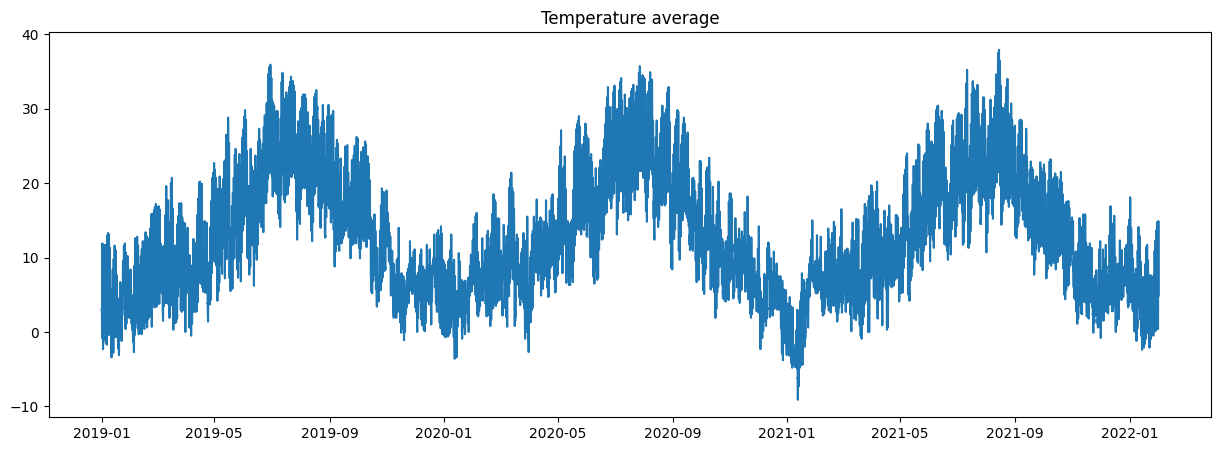

In [ ]:
X = df['time'].values
y = df['temperature'].values

plt.figure(figsize=(15,5))
plt.plot(X,y)
plt.title('Temperature average')

#  Machine Learning

## Bentuk batch

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

## MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1,1))

## Nilai ambang batas 10% dari skala data

In [ ]:
threshold_mae = (y.max() - y.min()) * 10/100
print(threshold_mae)

0.1


## Callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<threshold_mae and logs.get('val_mae')<threshold_mae):
      print("\nNilai MAE < 10% dari skala data!")
      self.model.stop_training = True
callbacks = myCallback()

## Membagi data train dan data validasi

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(y_train), len(y_valid))
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

21619 5405


## Membuat Model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

## Melatih model

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, validation_data=val_set, epochs=100,callbacks=[callbacks])

Epoch 1/100
216/216 [==============================] - 35s 143ms/step - loss: 0.0259 - mae: 0.1832 - val_loss: 0.0148 - val_mae: 0.1374
Epoch 2/100
216/216 [==============================] - 32s 146ms/step - loss: 0.0123 - mae: 0.1284 - val_loss: 0.0137 - val_mae: 0.1314
Epoch 3/100
216/216 [==============================] - 32s 147ms/step - loss: 0.0115 - mae: 0.1238 - val_loss: 0.0128 - val_mae: 0.1263
Epoch 4/100
216/216 [==============================] - 32s 144ms/step - loss: 0.0108 - mae: 0.1192 - val_loss: 0.0118 - val_mae: 0.1203
Epoch 5/100
216/216 [==============================] - 32s 148ms/step - loss: 0.0099 - mae: 0.1139 - val_loss: 0.0109 - val_mae: 0.1144
Epoch 6/100
216/216 [==============================] - 32s 147ms/step - loss: 0.0093 - mae: 0.1097 - val_loss: 0.0101 - val_mae: 0.1094
Epoch 7/100
216/216 [==============================] - 32s 146ms/step - loss: 0.0087 - mae: 0.1056 - val_loss: 0.0094 - val_mae: 0.1046
Epoch 8/100
216/216 [===========================

## Plot Grafik

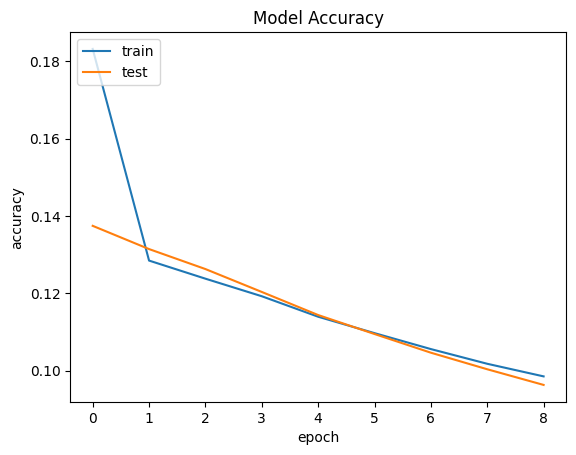

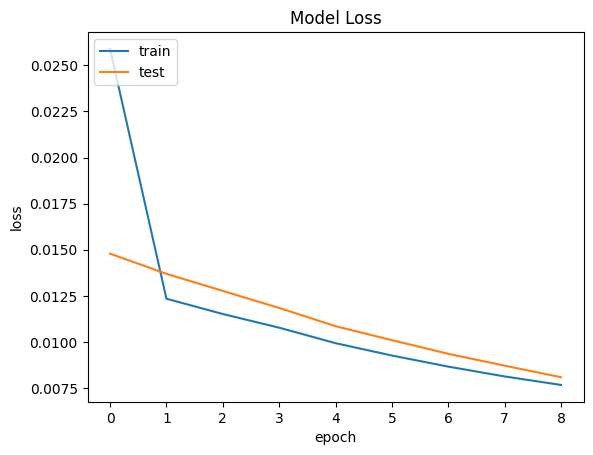

In [63]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()